In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import os
import numpy as np
import pandas as pd
import h5py
import gc
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [6]:
filepath = '/kaggle/input/deepsigio-hdf5-dataset-uncompressed/GOLD_XYZ_OSC.0001_1024.hdf5'

In [7]:
with h5py.File(filepath, 'r') as f:
    X = f['X'][:]
    Y = f['Y'][:]
    Z = f['Z'][:]

In [12]:
frame_index = 0
example_frame = X[frame_index]
I = example_frame[:, 0]
Q = example_frame[:, 1]

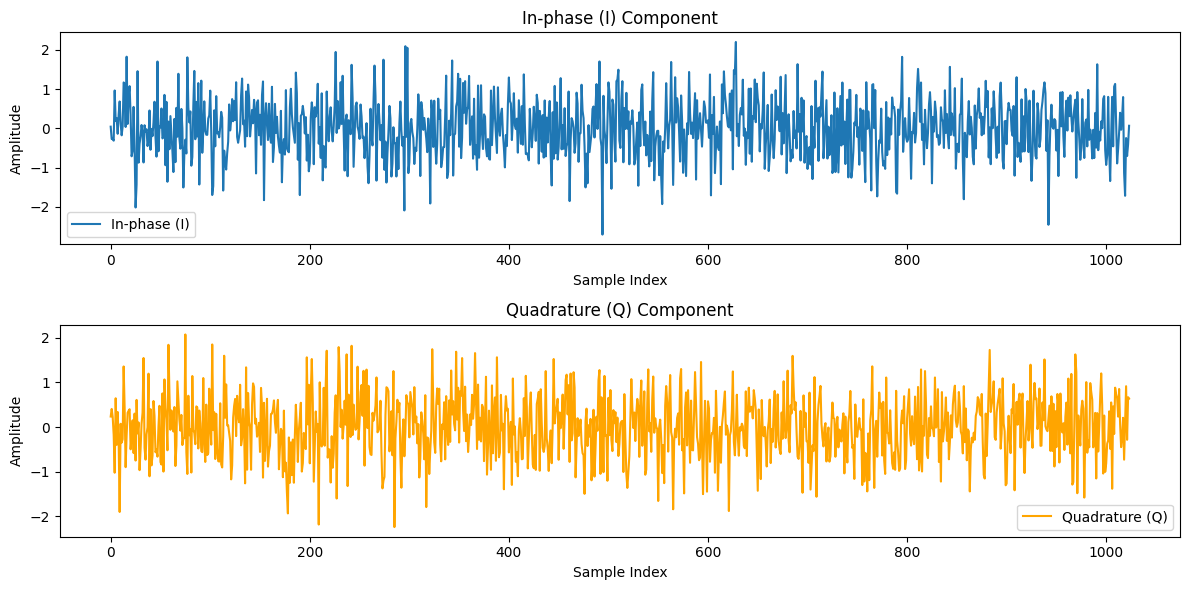

In [5]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(I, label='In-phase (I)')
plt.title('In-phase (I) Component')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Q, label='Quadrature (Q)', color='orange')
plt.title('Quadrature (Q) Component')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
print(I.shape,Q.shape)
print(X.shape)
print(Y.shape)
print(Z.shape)

(1024,) (1024,)
(2555904, 1024, 2)
(2555904, 24)
(2555904, 1)


In [8]:
rows = []
for i in range(Y.shape[0]):
    if np.any(Y[i, [8, 14, 18, 19, 20]] == 1):
        rows.append(True)
    else:
        rows.append(False)
# rows = np.any(Y[:, [8, 14, 18, 19, 20]] == 1, axis=1)

In [9]:
pd.DataFrame(rows).value_counts()

False    2023424
True      532480
Name: count, dtype: int64

In [10]:
new_X = X[rows]
new_y = Y[rows]
new_z = Z[rows]

In [16]:
print(new_X.shape, new_y.shape, new_z.shape)

(532480, 1024, 2) (532480, 24) (532480, 1)


In [11]:
del X
del Y
del Z
gc.collect()

0

In [12]:
batch_size = 2048
test_size = 0.2 
val_size = 0.15 

X_train_val, X_test, Y_train_val, Y_test, Z_train_val, Z_test = train_test_split(new_X, new_y, new_z, test_size=test_size, random_state=42)

X_train, X_val, Y_train, Y_val, Z_train, Z_val = train_test_split(X_train_val, Y_train_val, Z_train_val, test_size=val_size/(1-test_size), random_state=42)

In [8]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'X_val: {X_val.shape}')
print(f'Y_train: {Y_train.shape}')
print(f'Y_test: {Y_test.shape}')
print(f'Y_val: {Y_val.shape}')
print(f'Z_train: {Z_train.shape}')
print(f'Z_test: {Z_test.shape}')
print(f'Z_val: {Z_val.shape}')

X_train: (346112, 1024, 2)
X_test: (106496, 1024, 2)
X_val: (79872, 1024, 2)
Y_train: (346112, 24)
Y_test: (106496, 24)
Y_val: (79872, 24)
Z_train: (346112, 1)
Z_test: (106496, 1)
Z_val: (79872, 1)


In [13]:
print(Y_test[0])
print(Y_test[20000])
print(Y_test[10000])
print(Y_test[25000])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:
def convert_to_5_class_one_hot(Y):

    # Find the indices of the '1's in each row
    class_indices = np.argmax(Y, axis=1)

    # Define the mapping from 24-position index to 5-class index
    # You need to know which positions in your 24-vector correspond to which class
    mapping = {
        8: 0,
        14: 1,
        18: 2,
        19: 3,
        20: 4   
    }

    # Convert the 24-position indices to 5-class indices
    mapped_indices = np.array([mapping[idx] for idx in class_indices])

    # Create the one-hot encoded 5-class representation
    num_samples = Y.shape[0]
    one_hot_5_class = np.zeros((num_samples, 5), dtype=int)
    one_hot_5_class[np.arange(num_samples), mapped_indices] = 1

    return one_hot_5_class


In [15]:
Y_train = convert_to_5_class_one_hot(Y_train)
Y_test = convert_to_5_class_one_hot(Y_test)
Y_val = convert_to_5_class_one_hot(Y_val)

In [16]:
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'X_val: {X_val.shape}')
print(f'Y_train: {Y_train.shape}')
print(f'Y_test: {Y_test.shape}')
print(f'Y_val: {Y_val.shape}')
print(f'Z_train: {Z_train.shape}')
print(f'Z_test: {Z_test.shape}')
print(f'Z_val: {Z_val.shape}')

X_train: (346112, 1024, 2)
X_test: (106496, 1024, 2)
X_val: (79872, 1024, 2)
Y_train: (346112, 5)
Y_test: (106496, 5)
Y_val: (79872, 5)
Z_train: (346112, 1)
Z_test: (106496, 1)
Z_val: (79872, 1)


In [17]:
Y_train[:15]

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0]])

In [16]:
# train_dataset = tf.data.Dataset.from_tensor_slices(((X_train, Z_train), Y_train))
# train_dataset = train_dataset.batch(batch_size)
# train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# val_dataset = tf.data.Dataset.from_tensor_slices(((X_val, Z_val), Y_val))
# val_dataset = val_dataset.batch(batch_size)
# val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# test_dataset = tf.data.Dataset.from_tensor_slices(((X_test, Z_test), Y_test))
# test_dataset = test_dataset.batch(batch_size)
# test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


In [14]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024, 2), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.int64, name=None))>

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def create_cnn_model(input_length, num_classes):
    # Input Layers
    iq_input = layers.Input(shape=(input_length, 2), name='iq_input')

    conv1 = layers.Conv1D(filters=32, kernel_size=3, strides = 1, activation='relu')(iq_input)
    
    batch1 = layers.BatchNormalization()(conv1)
    
    pool1 = layers.MaxPool1D(pool_size=2, strides = 2)(batch1)
    
    drop_out1 = layers.Dropout(0.5)(pool1)

    conv2 = layers.Conv1D(filters=64, kernel_size=3, strides = 1, activation='relu')(drop_out1)

    batch2 = layers.BatchNormalization()(conv2)

    pool2 = layers.MaxPool1D(pool_size=2, strides = 2)(batch2)

    drop_out2 = layers.Dropout(0.5)(pool2)

    flattened_cnn = layers.Flatten()(drop_out2)

    output = layers.Dense(num_classes, activation='softmax')(flattened_cnn)

    model = Model(inputs=iq_input, outputs=output)
    
    return model


In [21]:
# import tensorflow as tf
# from tensorflow.keras import layers, Model

# def create_cnn_model(input_length, num_classes):
#     # Input Layers
#     iq_input = layers.Input(shape=(input_length, 2), name='iq_input')
#     snr_input = layers.Input(shape=(1,), name='snr_input')

#     # CNN Layers for I/Q Data
#     conv1 = layers.Conv1D(filters=32, kernel_size=3, strides = 1, activation='relu')(iq_input)
    
#     batch1 = layers.BatchNormalization()(conv1)
    
#     pool1 = layers.MaxPool1D(pool_size=2, strides = 2)(batch1)
    
#     drop_out1 = layers.Dropout(0.5)(pool1)
    
#     conv2 = layers.Conv1D(filters=64, kernel_size=3, strides = 1, activation='relu')(drop_out1)

#     batch2 = layers.BatchNormalization()(conv2)
    
#     pool2 = layers.MaxPool1D(pool_size=2, strides = 2)(batch2)

    
#     flattened_cnn = layers.Flatten()(pool2)

    
#     # expanded_snr = layers.Dense(flattened_cnn.shape[-1], activation='linear')(snr_input)

    
#     # concatenated_features = layers.concatenate([flattened_cnn, expanded_snr])

    
#     dense1 = layers.Dense(128, activation='relu')(flattened_cnn)#(concatenated_features)
    
#     drop_out2 = layers.Dropout(0.5)(dense1)
    
#     output = layers.Dense(num_classes, activation='softmax')(drop_out2)

    
#     model = Model(inputs=[iq_input, snr_input], outputs=output)
#     return model



In [16]:
model = create_cnn_model(1024, 5)
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ iq_input (InputLayer)                │ (None, 1024, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1022, 32)            │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1022, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 511, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 511, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 509, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 509, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 254, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 254, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16256)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │          81,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,101 (344.14 KB)

 Trainable params: 87,909 (343.39 KB)

 Non-trainable params: 192 (768.00 B)

In [17]:
output_dir = "/kaggle/working/"
with open(os.path.join(output_dir, 'model_summary.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)


Epoch 1/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 866s 5s/step - accuracy: 0.4523 - loss: 1.1426 - val_accuracy: 0.3937 - val_loss: 1.8107
Epoch 2/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 873s 5s/step - accuracy: 0.4746 - loss: 1.0790 - val_accuracy: 0.4041 - val_loss: 1.9803
Epoch 3/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 851s 5s/step - accuracy: 0.4965 - loss: 1.0387 - val_accuracy: 0.4033 - val_loss: 2.0603
Epoch 4/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 991s 6s/step - accuracy: 0.5114 - loss: 1.0121 - val_accuracy: 0.4046 - val_loss: 1.9368
Epoch 5/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 869s 5s/step - accuracy: 0.5167 - loss: 0.9964 - val_accuracy: 0.4067 - val_loss: 1.7978
52/52 ━━━━━━━━━━━━━━━━━━━━ 49s 920ms/step - accuracy: 0.4043 - loss: 1.8053
Test Loss: 1.8038
Test Accuracy: 0.4050

Training and Validation Results:
Epoch 1/5
  Train Loss: 1.1254, Train Accuracy: 0.4572
  Val Loss: 1.8107, Val Accuracy: 0.3937
Epoch 2/5
  Train Loss: 1.0702, Train Accuracy: 0.4800
  Val Loss: 1.9803, Val Accuracy: 0.4041
Epoch 3/5
  Train 

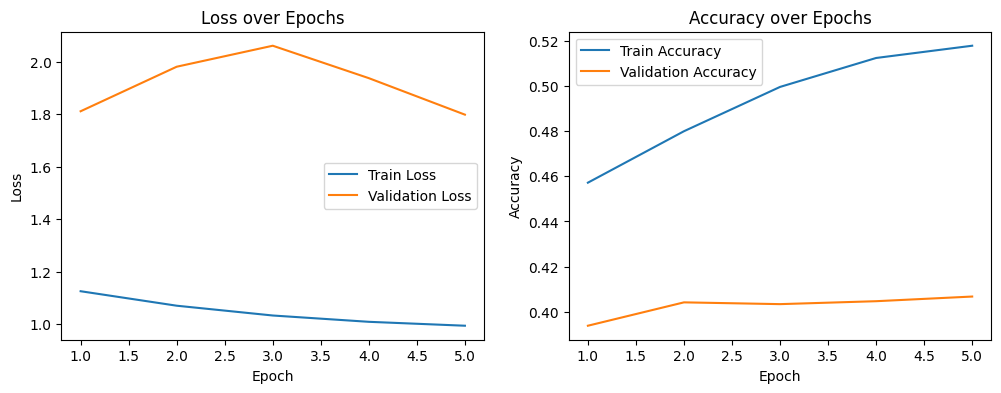

In [19]:
epochs = 5  
learning_rate = tf.Variable(0.0001, trainable=False)

tf.keras.backend.set_value(learning_rate, 0.0001)

history = model.fit(train_dataset, 
                    epochs=epochs, 
                    validation_data=val_dataset)


test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')


train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Print training and validation results
print("\nTraining and Validation Results:")
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'  Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}')
    print(f'  Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')


history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(output_dir, 'training_results.csv'), index=False)

model.save(os.path.join(output_dir, 'cnn_model.h5'))

print(f"Model summary and training results saved to {output_dir}")

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
model = tf.keras.models.load_model('/kaggle/input/simple_cnn_dsp/tensorflow2/simple_radio_cnn/1/cnn_model.h5')

In [19]:
signals_dict = {0:'BPSK', 1:'128QAM', 2:'64QAM', 3:'QPSK', 4:'256QAM'}

In [48]:
test_frame_index = 0
X_test_new_dim = tf.expand_dims(X_test[test_frame_index], axis = 0)
reshaped_tensor = tf.reshape(X_test_new_dim, (-1, 1024, 2))
print(reshaped_tensor.shape)

y_test_new_dim = tf.expand_dims(Y_test[test_frame_index], axis = 0)
reshaped_y = tf.reshape(y_test_new_dim, (-1,5))
print(reshaped_y.shape)

(1, 1024, 2)
(1, 5)


In [49]:
prediction_probabilities = model.predict(reshaped_tensor)
predicted_class = np.argmax(prediction_probabilities, axis=1)[0]
print(f"Predicted signal is : {signals_dict[predicted_class]}")

actual_class = np.argmax(reshaped_y, axis = 1)[0]
print(f"Actual signal is : {signals_dict[actual_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted signal is : 64QAM
Actual signal is : 64QAM


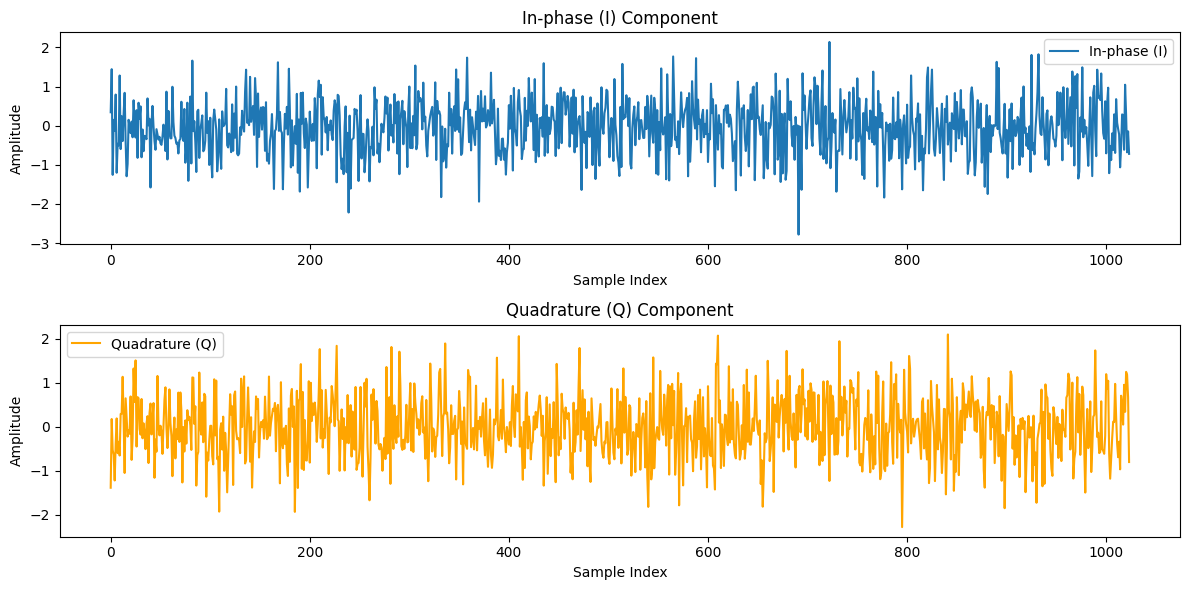

In [50]:
example_frame = X_test[test_frame_index]
I = example_frame[:, 0]
Q = example_frame[:, 1]
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(I, label='In-phase (I)')
plt.title('In-phase (I) Component')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Q, label='Quadrature (Q)', color='orange')
plt.title('Quadrature (Q) Component')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

'64QAM'

In [ ]:
import tensorflow as tf

# Define the model
def create_signal_noise_model():
    model = tf.keras.Sequential()
    
    # Input layer
    model.add(tf.keras.layers.Input(shape=(1024, 2)))
    
    # First Conv Layer
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='valid'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(tf.keras.layers.Dropout(0.5))  # Dropout for regularization

    # Second Conv Layer
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='valid'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=2))
    model.add(tf.keras.layers.Dropout(0.5))  # Dropout for regularization

    # Flatten layer
    model.add(tf.keras.layers.Flatten())

    # Dense layer
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))  # Dropout for regularization

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

    return model

# Create the model
model = create_signal_noise_model()

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()

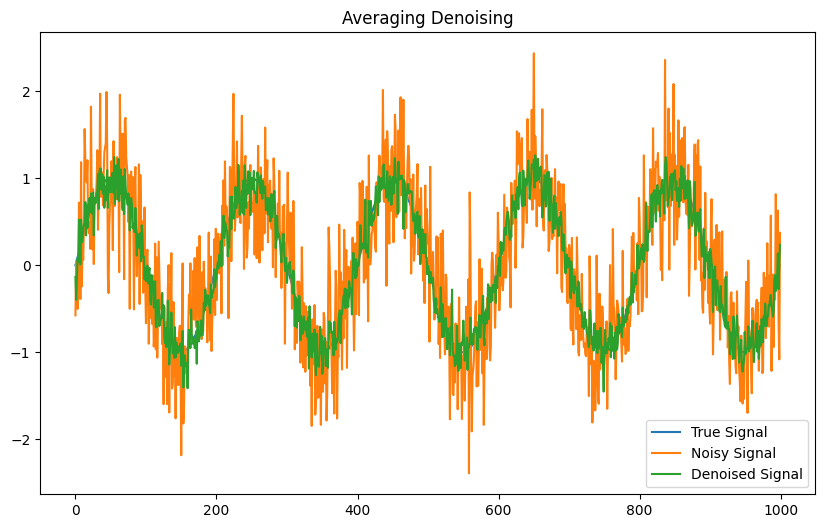

In [4]:
import numpy as np

def averaging_denoising(noisy_signal, num_averages):
    """
    Averages multiple samples of a noisy signal to reduce noise.

    Args:
        noisy_signal: A 2D numpy array where each row is a noisy signal sample.
        num_averages: The number of samples to average.

    Returns:
        The denoised signal.
    """
    if noisy_signal.shape[0] < num_averages:
        raise ValueError("Number of samples is less than num_averages.")

    averaged_signal = np.mean(noisy_signal[:num_averages, :], axis=0)
    return averaged_signal

# Example Usage
signal_length = 1000
num_samples = 10
true_signal = np.sin(np.linspace(0, 10*np.pi, signal_length))
noise = np.random.normal(0, 0.5, (num_samples, signal_length))
noisy_signal = true_signal + noise

denoised_signal = averaging_denoising(noisy_signal, num_samples)


plt.figure(figsize=(10,6))
plt.plot(true_signal, label='True Signal')
plt.plot(noisy_signal[0], label='Noisy Signal')
plt.plot(denoised_signal, label='Denoised Signal')
plt.legend()
plt.title('Averaging Denoising')
plt.show()